In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import dask
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
from scipy.interpolate import griddata # Other package for regridding
# Import some extra functions from utils folder
import sys

In [2]:
# qsub -IVX -l nodes=1:ppn=12,mem=16g,vmem=16g,walltime=04:00:00
import multiprocessing
multiprocessing.cpu_count()

64

In [3]:
# For parallelisation
from dask.distributed import Client
from dask import delayed
from dask import compute
client = Client(n_workers=4, threads_per_worker=3, memory_limit='4GB')
# client = Client()
client

Client Scheduler: tcp://127.0.0.1:33996 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 16.00 GB


In [4]:
client.close()

In [5]:
period = slice('2001-01','2001-12')
seasons = ['Annual','DJF','MAM','JJA','SON']
root_data_path = '/data/mmenegoz/AVHRR_MERGED/v2.0/2001/' # local, first test for only one year
save_data = '/data/mmenegoz/Alpine_snow_2001.nc'
# Alpine domain
latlim_ext,lonlim_ext=slice(44,48), slice(5,17)

In [6]:
# the data is extracted only the first time
from pathlib import Path
path = Path(save_data)
if path.is_file():
    print(f'The file {path} already exists')
else:
    print(f'The file {path} does not exist')
    print(f'The data is extracted')
    ds = xr.open_mfdataset(root_data_path+'*/*.nc', parallel=True)
    ds_alps=ds.sel(lat=latlim_ext, lon=lonlim_ext,time=period)
    ds_alps.to_netcdf(save_data)

The file /data/mmenegoz/Alpine_snow_2001.nc does not exist
The data is extracted


In [32]:
ds_alps

,Array,Chunk
Bytes,441.60 kB,1.28 kB
Shape,"(345, 80, 2)","(1, 80, 2)"
Count,1725 Tasks,345 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,1.32 MB,3.84 kB
Shape,"(345, 240, 2)","(1, 240, 2)"
Count,1725 Tasks,345 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [33]:
scf = ds_alps.scfg.where(ds_alps.scfg <= 100)

In [34]:
scf

,Array,Chunk
Bytes,26.50 MB,76.80 kB
Shape,"(345, 80, 240)","(1, 80, 240)"
Count,2070 Tasks,345 Chunks
Type,float32,numpy.ndarray


/home/mmenegoz/.conda/envs/martin_2021/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


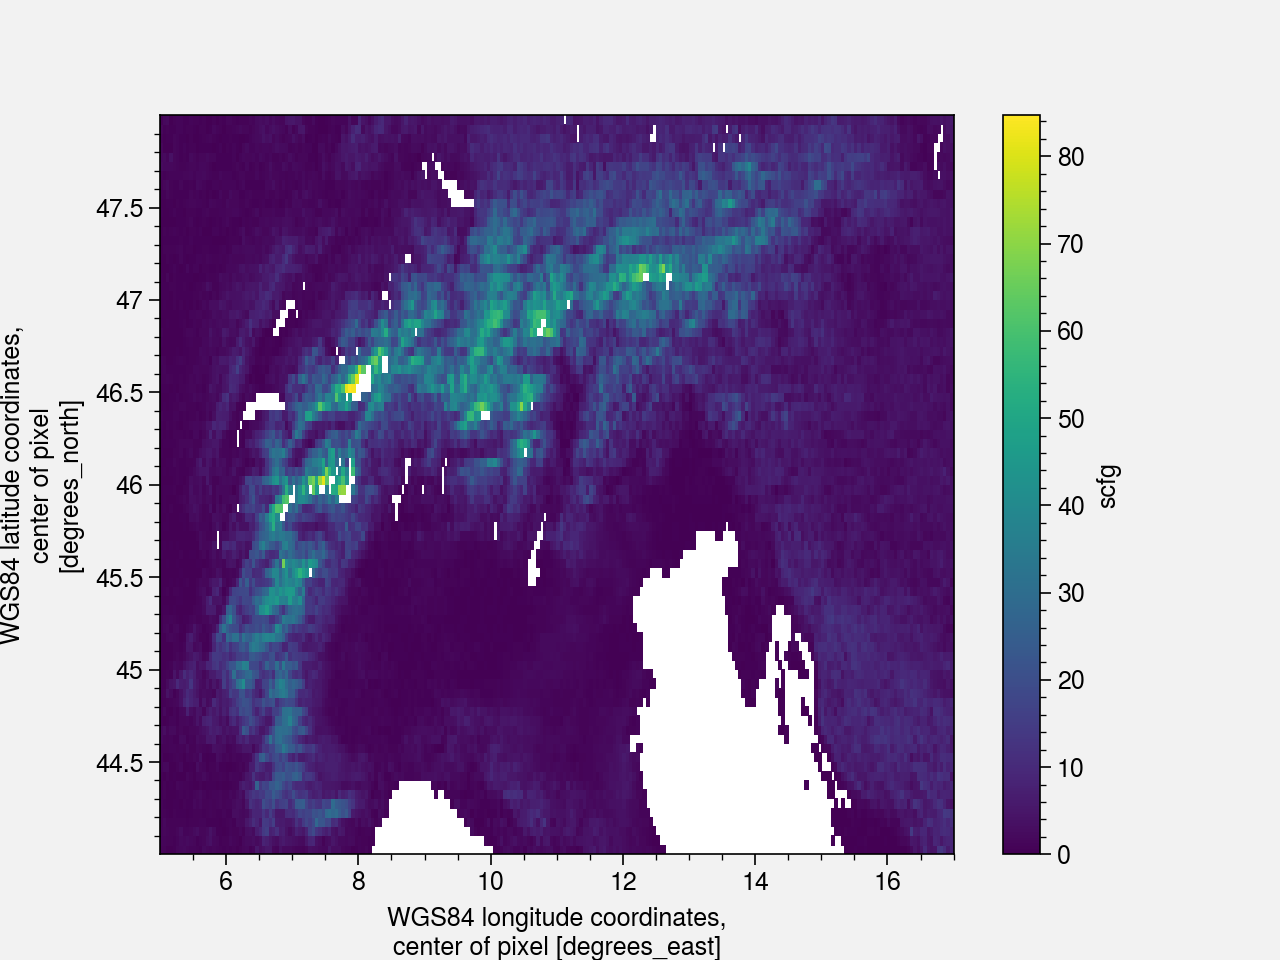

In [35]:
scf.mean('time').plot()

In [48]:
# Check data availability
scf = ds_alps.scfg.where(ds_alps.scfg <= 100)
data_coverage = ((scf.count('time') / scf.time.size)*100).load()

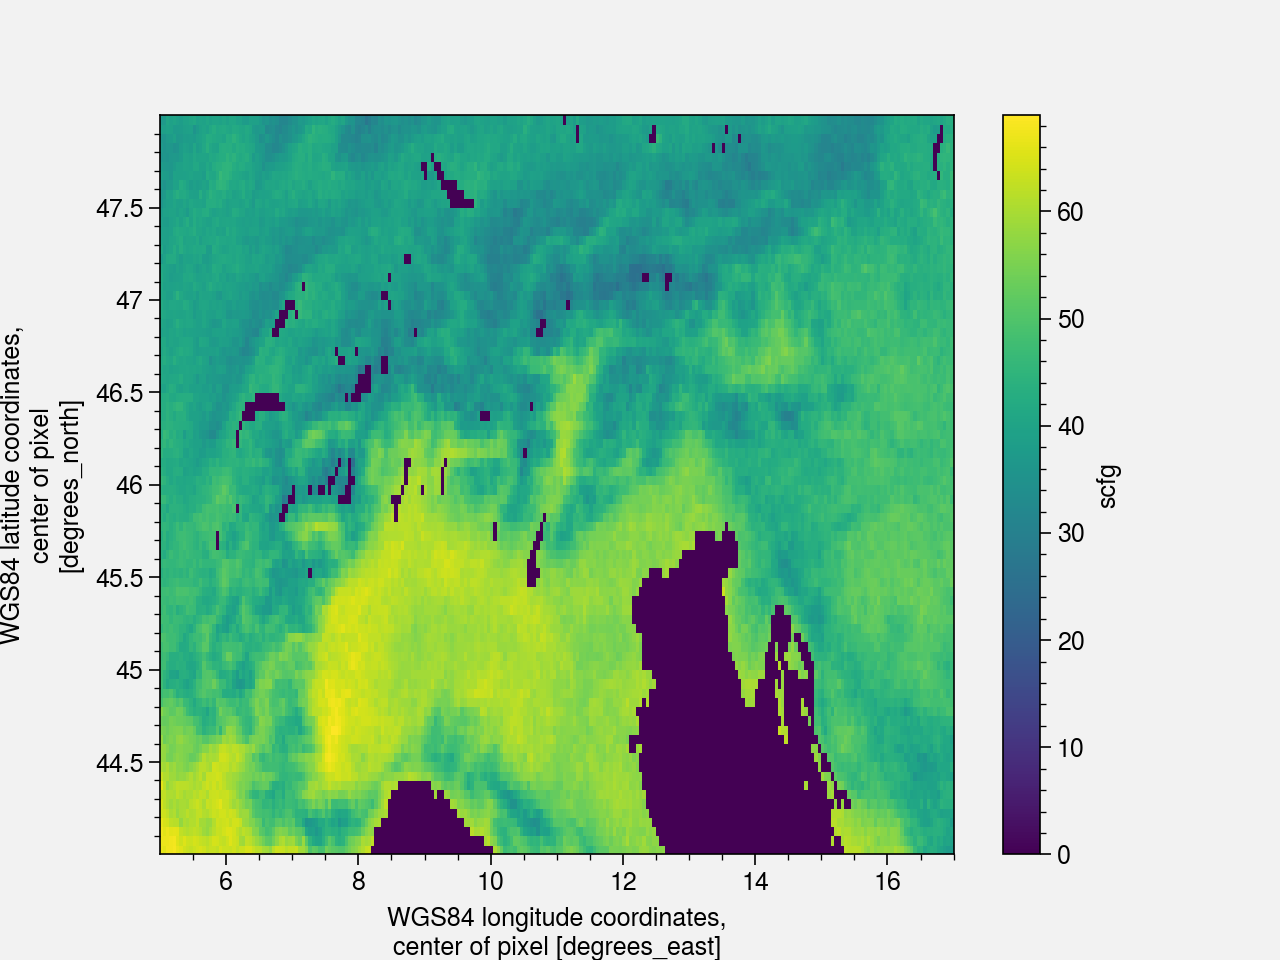

In [49]:
data_coverage.plot()

scfg:_FillValue = 255UB;

scfg:long_name = "Snow Cover Fraction on Ground" ;

scfg:units = "percent" ;

scfg:standard_name = "surface_snow_area_fraction" ;

scfg:valid_range = 0UB, 254UB ;

scfg:actual_range = 0UB, 100UB ;

scfg:flag_values = 205UB, 206UB, 210UB, 215UB, 254UB ;

scfg:flag_meanings = "Cloud Polar_Night_or_Night Water Permanent_Snow_and_Ice No_Satellite_Acquisition" ;

scfg:grid_mapping = "spatial_ref" ;

scfg:ancillary_variables = "scfg_unc" ;

scfg:missing_value = 255UB ;

In [40]:
MV_cloud=ds_alps.scfg.where(ds_alps.scfg == 205).count(dim='time')

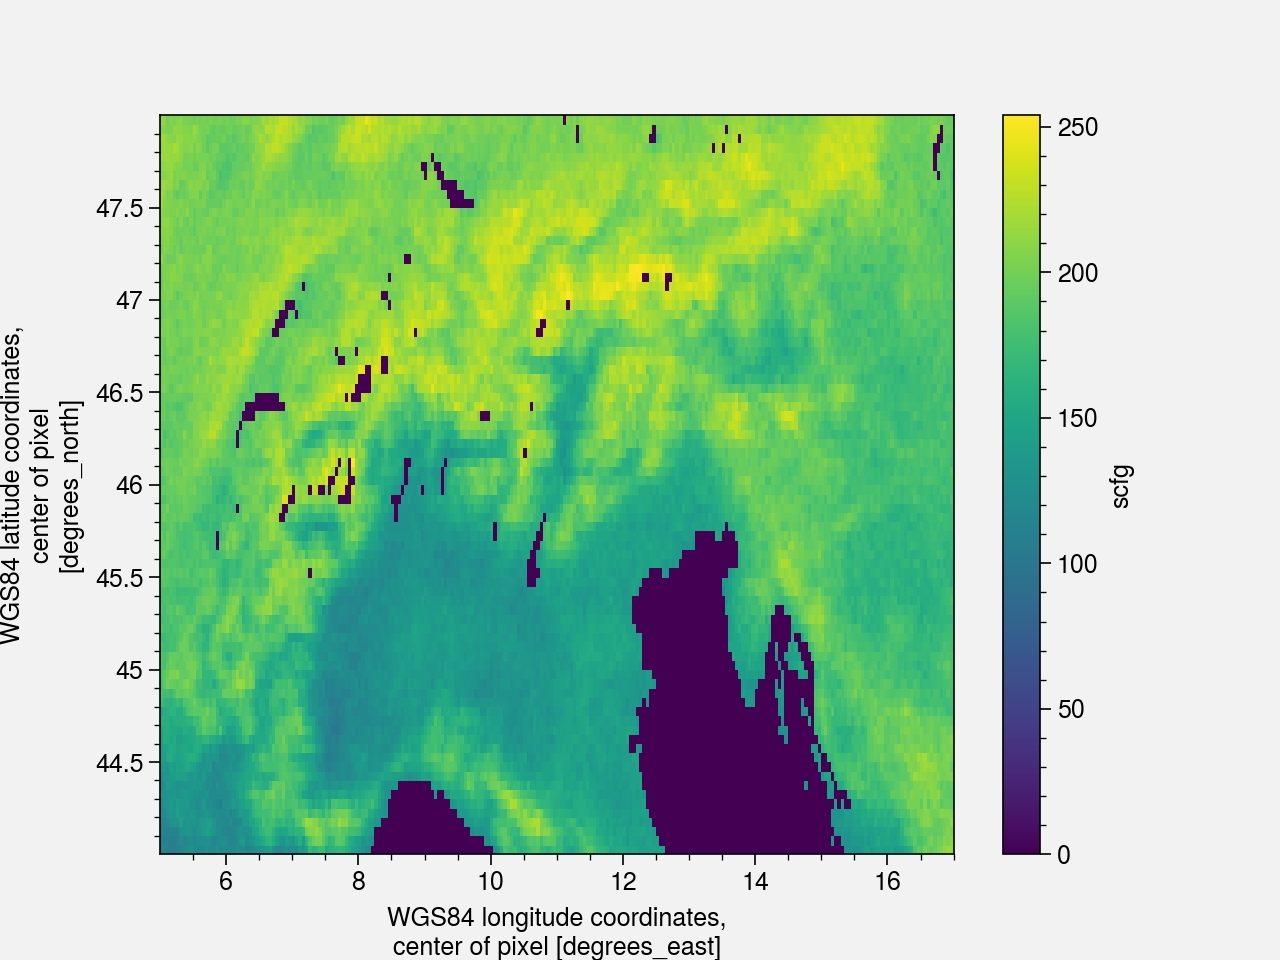

In [42]:
MV_cloud.plot()

In [ ]:
# Gap filling

In [51]:
scf_time_interp = scf.chunk({'time': -1}).interpolate_na('time', method='linear')
scf_time_interp

<xarray.DataArray 'scfg' (time: 345, lat: 80, lon: 240)>
dask.array<transpose, shape=(345, 80, 240), dtype=float64, chunksize=(345, 80, 240), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 5.025 5.075 5.125 5.175 ... 16.83 16.88 16.92 16.98
  * lat      (lat) float64 44.03 44.08 44.12 44.17 ... 47.83 47.88 47.92 47.97
  * time     (time) datetime64[ns] 2001-01-17 2001-01-18 ... 2001-12-31
Attributes:
    long_name:            Snow Cover Fraction on Ground
    units:                percent
    standard_name:        surface_snow_area_fraction
    valid_range:          [  0 254]
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    grid_mapping:         spatial_ref
    ancillary_variables:  scfg_unc

In [56]:
scf_interp = scf_time_interp.where(scf_time_interp <= 100)
data_coverage_interp = ((scf_interp.count('time') / scf_interp.time.size)*100).load()

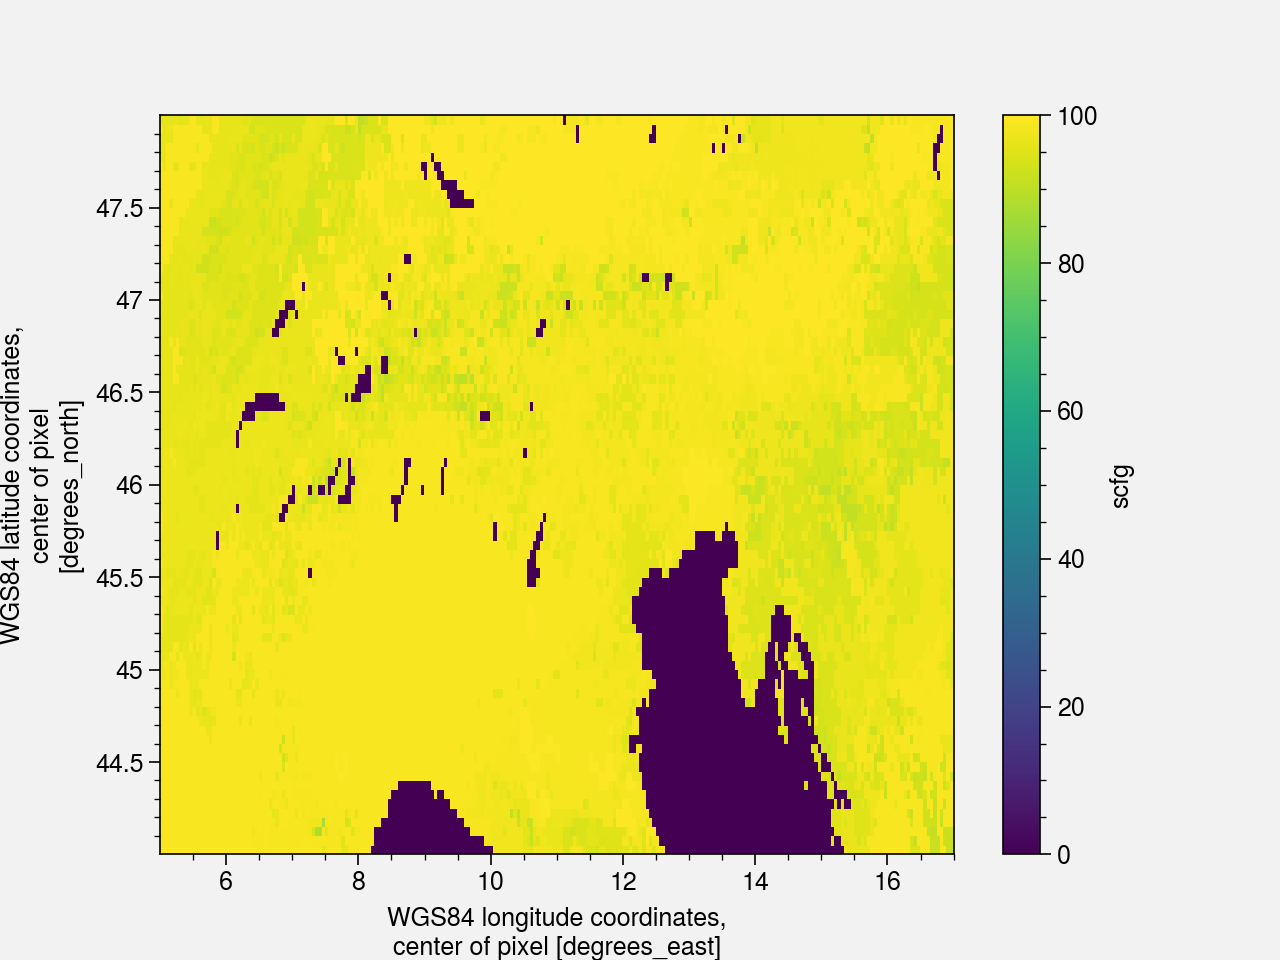

In [57]:
data_coverage_interp.plot()

In [5]:
# function for seasonal mean
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby("time.season").sum(dim="time")

In [16]:
ds.time.dt.days_in_month.groupby("time.season").sum()

<xarray.DataArray 'days_in_month' (season: 1)>
array([930])
Coordinates:
  * season   (season) object 'DJF'

In [ ]:
# To do list:
# O. When the data is already downloaded, skip the extraction step and download a netcdf file
# 1. Compute the number of missing values (percentage during the full period)
# 2. Fill the gaps
# 3. Compute and plot the monthly means
# 4. 